### Import packages, models, and copy training data to working directory

In [15]:
import torch
import numpy as np
from torch import nn
from scipy.stats import logistic
import torch.nn.functional as F
from collections import OrderedDict
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from matplotlib.colors import Normalize
import pandas as pd
import sys
sys.path.append("../models")
from models import *

In [16]:
z_dim = 512
w_dim = 512
mapping_layers = 8
mapping_activation = "LeakyReLU"

In [17]:
import os
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
!cp "./drive/MyDrive/StyleGAN/training_data.zip" '.'

In [20]:
!unzip -q training_data.zip
!rm training_data.zip

In [30]:
learning_rate = 0.015
batch_size = 8
res = 128
device = "cuda"

In [32]:
print(torch.cuda.is_available(), ", ", torch.cuda.device_count(), ", ", torch.cuda.get_device_name(0))


True ,  1 ,  Tesla V100-SXM2-16GB


### Import training data, split into training & valid sets

In [33]:
training_path = "./training_data/"

transform = transforms.Compose(
    [
        transforms.Resize(res),
        transforms.RandomCrop((res, res), padding=None),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ColorJitter(saturation=(0.9, 1.2),
                    contrast = (0.9, 1.1),),
        transforms.ToTensor()
    ]
)

class ImageDataset(Dataset):
    def __init__(self, training_path):
        self.training_path = training_path
        self.images_path = os.listdir(training_path)
    
    def __len__(self):
        return len(self.images_path)
    
    def __getitem__(self, index):
        path = self.training_path + self.images_path[index]
        image = Image.open(path)
        tensor = transform(image).to(device)
        
        return tensor

ds_photo = ImageDataset(training_path)

n_valid = 450
n_train = len(ds_photo) - n_valid
ds_train,ds_valid = random_split(ds_photo,[n_train,n_valid], generator=torch.Generator().manual_seed(0))
dl_photo = DataLoader(ds_train, shuffle=True, batch_size=batch_size, drop_last=True, num_workers=0)
dl_valid = DataLoader(ds_valid, shuffle=True, batch_size=batch_size, drop_last=True, num_workers=0)

In [34]:
print(len(ds_photo))
print(len(dl_photo))

6236
723


### Instantiate Models, load weights

In [48]:

gen = Generator().to(device)
disc = Discriminator().to(device)


gen_optim = torch.optim.Adam(gen.parameters(), lr=learning_rate, betas=(0., 0.99))
disc_optim = torch.optim.Adam(disc.parameters(), lr=learning_rate, betas=(0., 0.99))


stage = 6
gen.load_state_dict(torch.load("./drive/MyDrive/StyleGAN/train_final_0/stage" + str(stage) + "gen_parameter.pkl"))
disc.load_state_dict(torch.load("./drive/MyDrive/StyleGAN/train_final_0/stage" + str(stage) + "disc_parameter.pkl"))





<All keys matched successfully>

### Define Loss with R1 penalty

In [49]:


def R1Penalty(dis, real_img, height, alpha):

        real_img = torch.autograd.Variable(real_img, requires_grad=True)
        real_logit = dis(real_img, height, alpha)
        real_logit = torch.sum(real_logit) 

        real_grads = torch.autograd.grad(outputs=real_logit, inputs=real_img, create_graph=True, retain_graph=True)[0]
        r1_penalty = torch.sum(torch.mul(real_grads, real_grads), axis = [1, 2, 3]).view((-1, 1))
        return r1_penalty

def dis_loss(dis, real_samps, fake_samps, height, alpha, r1_gamma=10.0):
        # Obtain predictions
        r_preds = dis(real_samps, height, alpha)
        f_preds = dis(fake_samps, height, alpha)

        loss = nn.Softplus()(f_preds) + nn.Softplus()(-r_preds)

        if r1_gamma != 0.0:
            r1_penalty = R1Penalty(dis, real_samps.detach(), height, alpha) * (r1_gamma * 0.5)
            loss += r1_penalty
        return torch.mean(loss)

def gene_loss(dis, real_samps, fake_samps, height, alpha):
        f_preds = dis(fake_samps, height, alpha)

        return torch.mean(nn.Softplus()(-f_preds))



### Train!

In [51]:

GRAD_CLIP = 10.
def training_step(real_photo, stage, alpha):
    
    gen.train()
    disc.train()
    
    disc_loss_sum = 0
    disc_train_times = 1
    for i in range(disc_train_times):
      disc_optim.zero_grad()
      batch_size = real_photo.shape[0]
      z = torch.randn((batch_size, z_dim)).to(device)
      with torch.no_grad():
          fake_photo = gen.forward(z, stage=stage, alpha=alpha)
      res = fake_photo.shape[2]
      real_photo = nn.AvgPool2d(real_photo.shape[2] // res)(real_photo)
      real_photo = nn.Upsample(scale_factor=2)(nn.AvgPool2d(2)(real_photo)) * (1 - alpha) + real_photo * alpha
    
      disc_loss = dis_loss(disc, real_photo, fake_photo, stage, alpha)
      disc_loss_sum += disc_loss.item()
      torch.nn.utils.clip_grad_norm_(disc.parameters(), GRAD_CLIP)
      disc_loss.backward()
      disc_optim.step()
    
    gen_loss_sum = 0
    gen_train_times = 1
    for i in range(gen_train_times):
      disc.eval()
      gen_optim.zero_grad()
      z = torch.randn((batch_size, z_dim)).to(device)
      fake_photo = gen.forward(z, stage=stage, alpha=alpha)
      res = fake_photo.shape[2]
      real_photo = nn.AvgPool2d(real_photo.shape[2] // res)(real_photo)
      real_photo = nn.Upsample(scale_factor=2)(nn.AvgPool2d(2)(real_photo)) * (1 - alpha) + real_photo * alpha
      gen_loss = gene_loss(disc, real_photo, fake_photo, stage, alpha)
      gen_loss_sum += gen_loss.item()
      
      gen_loss.backward()
      torch.nn.utils.clip_grad_norm_(gen.parameters(), GRAD_CLIP)
      gen_optim.step()

    
    return gen_loss_sum / gen_train_times, disc_loss_sum / disc_train_times


def show_tensor_images(image_tensor, size, num_images=9):

    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=int(np.sqrt(num_images)))
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()
    
    
def eval_step(real_photo, stage, alpha, verbose=True, seed=2):
    gen.eval()
    disc.eval()
    
    with torch.no_grad():
        batch_size = real_photo.shape[0]
        np.random.seed(seed)
        z = np.random.randn(batch_size, z_dim)
        np.random.seed(None)
        z = torch.from_numpy(z).float().to(device)
        fake_photo = gen.forward(z, stage=stage, alpha=alpha)
        res = fake_photo.shape[2]
        real_photo = nn.AvgPool2d(real_photo.shape[2] // res)(real_photo)
        real_photo = nn.Upsample(scale_factor=2)(nn.AvgPool2d(2)(real_photo)) * (1 - alpha) + real_photo * alpha

        disc_for_real = disc.forward(real_photo, stage, alpha).cpu().numpy().T[0]
        disc_for_fake = disc.forward(fake_photo, stage, alpha).cpu().numpy().T[0]
    if verbose:
      size = (3, res, res)
      
      plt.rcParams['figure.figsize'] = (5, 5)
      show_tensor_images(fake_photo.cpu(), size, num_images=9)

    return disc_for_real, disc_for_fake

step: 2044960 stage: 6  alpha: 1.0  gen loss: 1.8890767097473145  disc loss: 0.6483027338981628
step: 2044970 stage: 6  alpha: 1.0  gen loss: 1.6649531126022339  disc loss: 0.7427240014076233
step: 2044980 stage: 6  alpha: 1.0  gen loss: 2.0356104373931885  disc loss: 0.5164292454719543
step: 2044990 stage: 6  alpha: 1.0  gen loss: 2.1504735946655273  disc loss: 0.6951829791069031
step: 2045000 stage: 6  alpha: 1.0  gen loss: 1.7059917449951172  disc loss: 0.5841436386108398


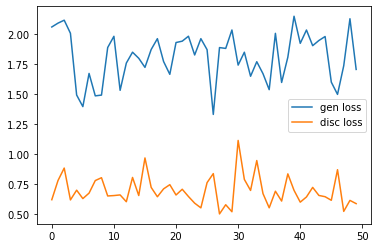

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truncating...


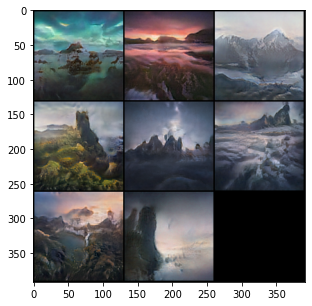

Truncating...
training set: 2.0879455 valid set: 1.7016332 generated set: -1.6590292


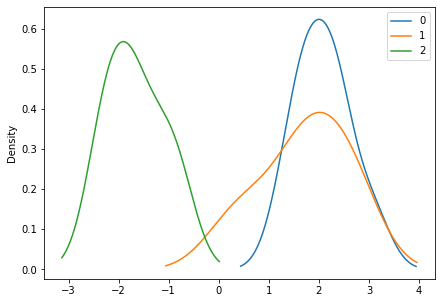

Truncating...
difference between images from same latents:  3272.6474609375
difference per pixel:  19.97465491294861 %
step: 2045010 stage: 6  alpha: 1.0  gen loss: 1.5169212818145752  disc loss: 0.6372795701026917
step: 2045020 stage: 6  alpha: 1.0  gen loss: 1.7630510330200195  disc loss: 0.6786558628082275
step: 2045030 stage: 6  alpha: 1.0  gen loss: 1.22313392162323  disc loss: 0.8112846612930298
step: 2045040 stage: 6  alpha: 1.0  gen loss: 1.5498168468475342  disc loss: 0.711878776550293
step: 2045050 stage: 6  alpha: 1.0  gen loss: 1.9011499881744385  disc loss: 0.6422173976898193
step: 2045060 stage: 6  alpha: 1.0  gen loss: 1.7587270736694336  disc loss: 0.6753740906715393
step: 2045070 stage: 6  alpha: 1.0  gen loss: 2.0629563331604004  disc loss: 0.6765998601913452
step: 2045080 stage: 6  alpha: 1.0  gen loss: 2.001669406890869  disc loss: 0.8305976390838623
step: 2045090 stage: 6  alpha: 1.0  gen loss: 1.8932276964187622  disc loss: 0.6640028357505798
step: 2045100 stage: 

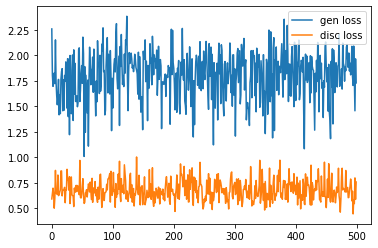

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truncating...


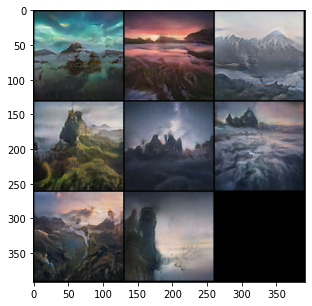

Truncating...
training set: 0.99983114 valid set: 1.6474249 generated set: -1.6675717


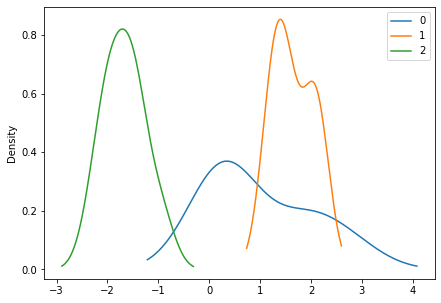

Truncating...
difference between images from same latents:  0.7991515398025513
difference per pixel:  0.004877633909927681 %
step: 2045510 stage: 6  alpha: 1.0  gen loss: 1.7784576416015625  disc loss: 0.5809568166732788
step: 2045520 stage: 6  alpha: 1.0  gen loss: 1.710294485092163  disc loss: 0.6596997976303101
step: 2045530 stage: 6  alpha: 1.0  gen loss: 1.2394039630889893  disc loss: 0.6779961585998535
step: 2045540 stage: 6  alpha: 1.0  gen loss: 2.034514904022217  disc loss: 0.662459135055542
step: 2045550 stage: 6  alpha: 1.0  gen loss: 2.186262607574463  disc loss: 0.6198609471321106
step: 2045560 stage: 6  alpha: 1.0  gen loss: 1.6999943256378174  disc loss: 0.7214947938919067
step: 2045570 stage: 6  alpha: 1.0  gen loss: 2.0219993591308594  disc loss: 0.5142766237258911
step: 2045580 stage: 6  alpha: 1.0  gen loss: 1.8758538961410522  disc loss: 0.5642557144165039
step: 2045590 stage: 6  alpha: 1.0  gen loss: 2.0581746101379395  disc loss: 0.6467529535293579
step: 2045600 s

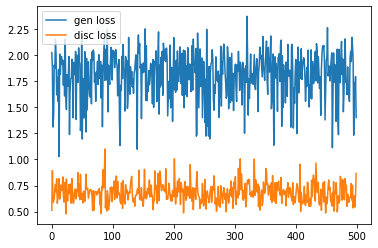

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truncating...


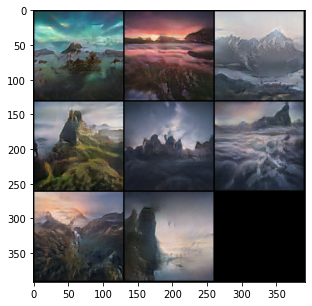

Truncating...
training set: 0.854439 valid set: 1.6235504 generated set: -1.53836


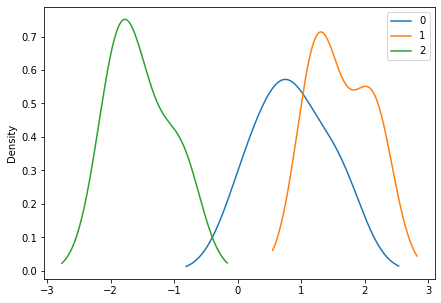

Truncating...
difference between images from same latents:  7.920513153076172
difference per pixel:  0.04834297578781843 %
step: 2046010 stage: 6  alpha: 1.0  gen loss: 1.9767944812774658  disc loss: 0.6868228912353516
step: 2046020 stage: 6  alpha: 1.0  gen loss: 1.8806496858596802  disc loss: 0.6636196970939636
step: 2046030 stage: 6  alpha: 1.0  gen loss: 1.975278615951538  disc loss: 0.5584160089492798
step: 2046040 stage: 6  alpha: 1.0  gen loss: 1.712808609008789  disc loss: 0.5051103830337524
step: 2046050 stage: 6  alpha: 1.0  gen loss: 1.9451853036880493  disc loss: 0.7128368020057678
step: 2046060 stage: 6  alpha: 1.0  gen loss: 1.4381954669952393  disc loss: 0.6405034065246582
step: 2046070 stage: 6  alpha: 1.0  gen loss: 1.5829777717590332  disc loss: 0.6774597764015198
step: 2046080 stage: 6  alpha: 1.0  gen loss: 1.6972938776016235  disc loss: 0.5084319710731506
step: 2046090 stage: 6  alpha: 1.0  gen loss: 1.2193162441253662  disc loss: 0.6221376061439514
step: 2046100 s

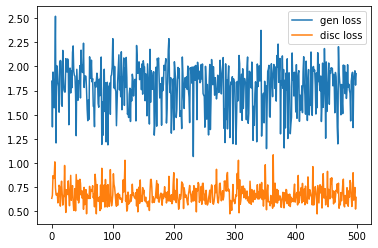

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truncating...


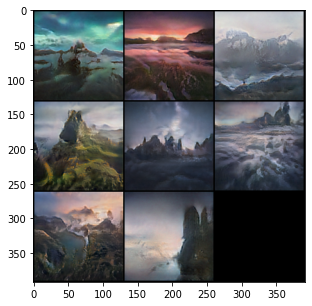

Truncating...
training set: 1.474333 valid set: 1.5103881 generated set: -1.7381539


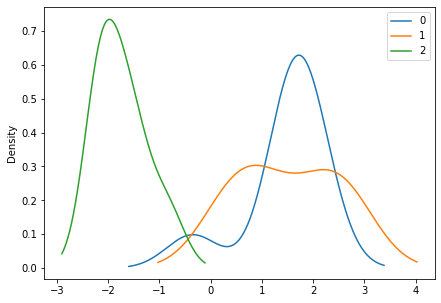

Truncating...
difference between images from same latents:  4.52876091003418
difference per pixel:  0.027641362976282835 %
step: 2046510 stage: 6  alpha: 1.0  gen loss: 1.6875271797180176  disc loss: 0.8490681052207947
step: 2046520 stage: 6  alpha: 1.0  gen loss: 1.8751143217086792  disc loss: 0.8242835402488708
step: 2046530 stage: 6  alpha: 1.0  gen loss: 1.7996282577514648  disc loss: 0.7940932512283325
step: 2046540 stage: 6  alpha: 1.0  gen loss: 1.9215984344482422  disc loss: 0.49952030181884766
step: 2046550 stage: 6  alpha: 1.0  gen loss: 1.9919843673706055  disc loss: 0.8117085695266724
step: 2046560 stage: 6  alpha: 1.0  gen loss: 1.3988920450210571  disc loss: 0.7248308658599854
step: 2046570 stage: 6  alpha: 1.0  gen loss: 1.9723292589187622  disc loss: 0.650980532169342
step: 2046580 stage: 6  alpha: 1.0  gen loss: 1.897552728652954  disc loss: 0.684866726398468
step: 2046590 stage: 6  alpha: 1.0  gen loss: 1.768650770187378  disc loss: 0.7655929923057556
step: 2046600 st

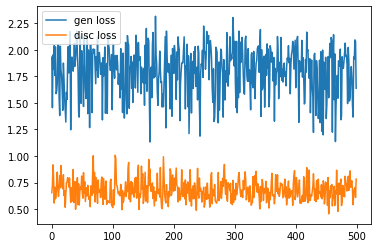

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truncating...


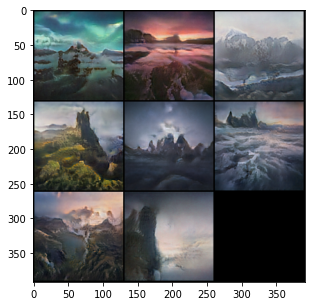

Truncating...
training set: 1.1263542 valid set: 1.4246042 generated set: -1.758162


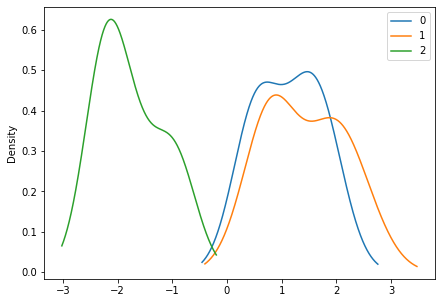

Truncating...
difference between images from same latents:  4.922382831573486
difference per pixel:  0.030043840524740517 %
step: 2047010 stage: 6  alpha: 1.0  gen loss: 1.8574554920196533  disc loss: 0.6697856187820435
step: 2047020 stage: 6  alpha: 1.0  gen loss: 1.8424901962280273  disc loss: 0.7280440330505371
step: 2047030 stage: 6  alpha: 1.0  gen loss: 1.9314546585083008  disc loss: 0.6927295923233032
step: 2047040 stage: 6  alpha: 1.0  gen loss: 1.8699252605438232  disc loss: 0.7275322675704956
step: 2047050 stage: 6  alpha: 1.0  gen loss: 1.9966156482696533  disc loss: 0.723017692565918
step: 2047060 stage: 6  alpha: 1.0  gen loss: 1.4380121231079102  disc loss: 0.8028636574745178
step: 2047070 stage: 6  alpha: 1.0  gen loss: 1.2035819292068481  disc loss: 0.7710958123207092
step: 2047080 stage: 6  alpha: 1.0  gen loss: 1.9826737642288208  disc loss: 0.5871371030807495
step: 2047090 stage: 6  alpha: 1.0  gen loss: 1.9548139572143555  disc loss: 0.6321437954902649
step: 2047100

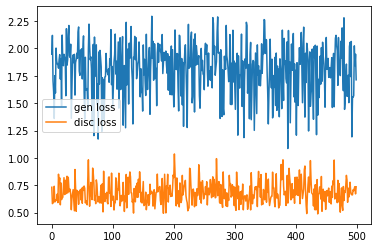

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truncating...


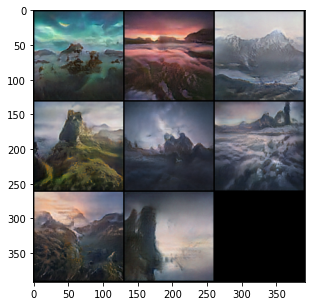

Truncating...
training set: 1.712899 valid set: 1.6049731 generated set: -1.5954623


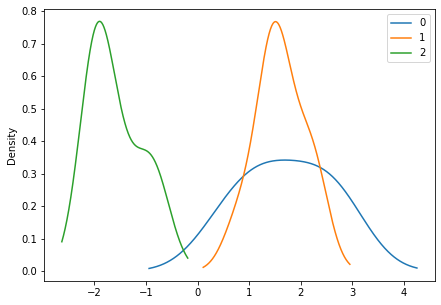

Truncating...
difference between images from same latents:  6.2566938400268555
difference per pixel:  0.03818782861344516 %
step: 2047510 stage: 6  alpha: 1.0  gen loss: 1.7780439853668213  disc loss: 0.6910542249679565
step: 2047520 stage: 6  alpha: 1.0  gen loss: 1.9453749656677246  disc loss: 0.5945223569869995
step: 2047530 stage: 6  alpha: 1.0  gen loss: 1.4070037603378296  disc loss: 0.6780117750167847
step: 2047540 stage: 6  alpha: 1.0  gen loss: 1.765147089958191  disc loss: 0.596119225025177
step: 2047550 stage: 6  alpha: 1.0  gen loss: 1.9056710004806519  disc loss: 0.6383492946624756
step: 2047560 stage: 6  alpha: 1.0  gen loss: 1.5677560567855835  disc loss: 0.6200911402702332
step: 2047570 stage: 6  alpha: 1.0  gen loss: 1.743586540222168  disc loss: 0.66925048828125
step: 2047580 stage: 6  alpha: 1.0  gen loss: 1.6713889837265015  disc loss: 0.5486971735954285
step: 2047590 stage: 6  alpha: 1.0  gen loss: 1.969763159751892  disc loss: 0.6170148253440857
step: 2047600 stag

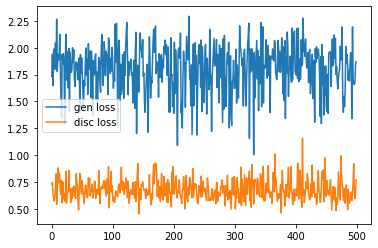

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truncating...


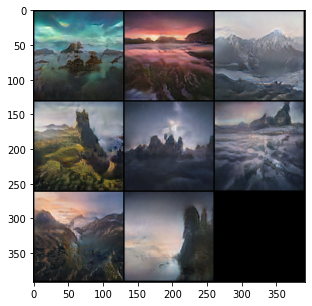

Truncating...
training set: 1.261807 valid set: 1.3322452 generated set: -1.75839


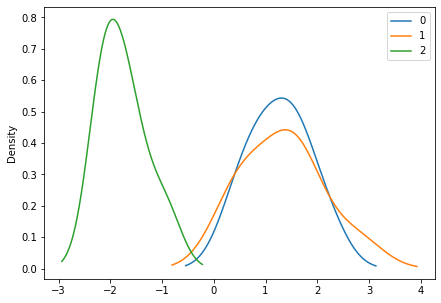

Truncating...
difference between images from same latents:  2.398329019546509
difference per pixel:  0.014638238644693047 %
step: 2048010 stage: 6  alpha: 1.0  gen loss: 1.64027738571167  disc loss: 1.1475749015808105
step: 2048020 stage: 6  alpha: 1.0  gen loss: 1.4932609796524048  disc loss: 0.7179303765296936
step: 2048030 stage: 6  alpha: 1.0  gen loss: 1.5325056314468384  disc loss: 0.6521577835083008
step: 2048040 stage: 6  alpha: 1.0  gen loss: 1.9085462093353271  disc loss: 0.7845884561538696
step: 2048050 stage: 6  alpha: 1.0  gen loss: 1.9456071853637695  disc loss: 0.5733456611633301
step: 2048060 stage: 6  alpha: 1.0  gen loss: 1.8686399459838867  disc loss: 0.7202848196029663
step: 2048070 stage: 6  alpha: 1.0  gen loss: 1.76953125  disc loss: 0.7781809568405151
step: 2048080 stage: 6  alpha: 1.0  gen loss: 2.1619019508361816  disc loss: 0.5528324246406555
step: 2048090 stage: 6  alpha: 1.0  gen loss: 1.6915925741195679  disc loss: 0.5994181632995605
step: 2048100 stage: 6

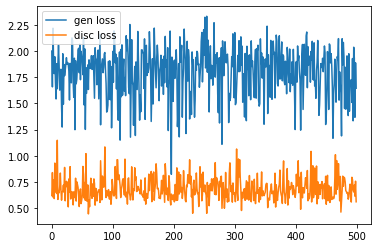

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truncating...


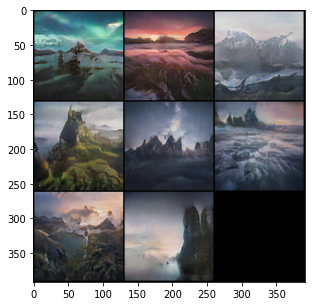

Truncating...
training set: 1.6641585 valid set: 1.0102434 generated set: -1.8586187


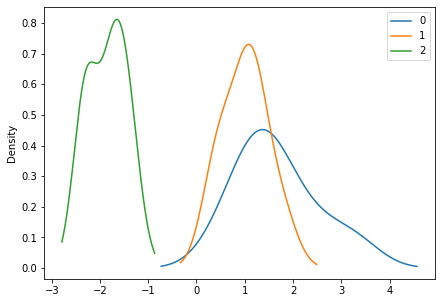

Truncating...
difference between images from same latents:  8.93860149383545
difference per pixel:  0.054556893883273005 %
step: 2048510 stage: 6  alpha: 1.0  gen loss: 1.9726755619049072  disc loss: 0.7413418889045715
step: 2048520 stage: 6  alpha: 1.0  gen loss: 1.6096694469451904  disc loss: 0.6894387006759644
step: 2048530 stage: 6  alpha: 1.0  gen loss: 1.9440255165100098  disc loss: 0.5988085269927979
step: 2048540 stage: 6  alpha: 1.0  gen loss: 1.9421262741088867  disc loss: 0.7642999887466431
step: 2048550 stage: 6  alpha: 1.0  gen loss: 1.9422253370285034  disc loss: 0.83892822265625
step: 2048560 stage: 6  alpha: 1.0  gen loss: 1.6851165294647217  disc loss: 0.5669175386428833
step: 2048570 stage: 6  alpha: 1.0  gen loss: 2.0847909450531006  disc loss: 0.572263240814209
step: 2048580 stage: 6  alpha: 1.0  gen loss: 2.1459975242614746  disc loss: 0.7337669134140015
step: 2048590 stage: 6  alpha: 1.0  gen loss: 1.976745843887329  disc loss: 0.8286256790161133
step: 2048600 sta

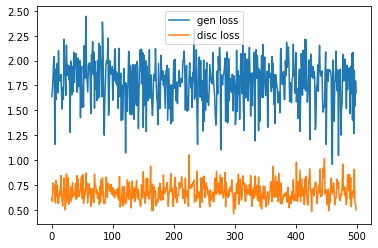

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truncating...


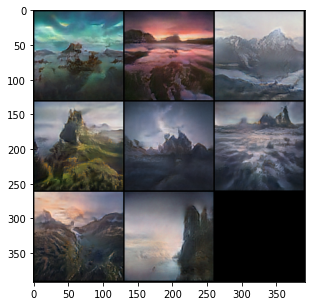

Truncating...
training set: 1.8328454 valid set: 1.6755128 generated set: -1.6538808


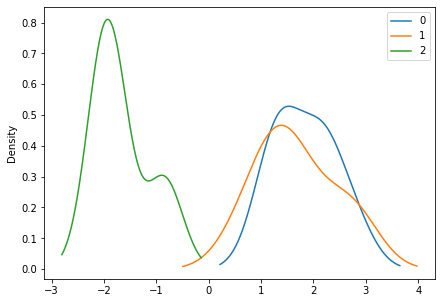

Truncating...
difference between images from same latents:  7.53994607925415
difference per pixel:  0.046020178706385195 %
step: 2049010 stage: 6  alpha: 1.0  gen loss: 1.8156603574752808  disc loss: 0.8429736495018005
step: 2049020 stage: 6  alpha: 1.0  gen loss: 1.7427215576171875  disc loss: 0.6673167943954468
step: 2049030 stage: 6  alpha: 1.0  gen loss: 1.552072286605835  disc loss: 0.5783097743988037
step: 2049040 stage: 6  alpha: 1.0  gen loss: 1.8328731060028076  disc loss: 0.5783699750900269


In [ ]:

stage = 6
step = 2044950 #[4*4: 6000*256, 8*8: 23720*256, 16*16: 45830*256, 32*32: 302960*64, 64*64: 615030*32, 128*128: 2044950*8] (resolution: step * batch size)
alpha = 1.
epochs = 50000 
change_alpha_step = 4000
view_photo_step = 500
#change_stage_step = 20000 # change manually 


gen_losses = []
disc_losses = []
disc_for_reals = []
disc_for_fakes = []

try: ave_image
except: ave_image = 0
if step == 0: ave_image = 0


for epoch in range(epochs):
    for real_photo in dl_photo:
        gen_loss, disc_loss = training_step(real_photo, stage, alpha)
        gen_losses.append(gen_loss)
        disc_losses.append(disc_loss)

        step += 1

        if step % change_alpha_step == 0:
            alpha += 0.01
            alpha = min(alpha, 1.)

        if step % 10 == 0:
            print("step: " + str(step), "stage: " + str(stage), " alpha: " + str(alpha), " gen loss: " + str(gen_loss), " disc loss: " + str(disc_loss))
            try:
                with open("./drive/MyDrive/StyleGAN/train_final_0/stage" + str(stage) + "losses.txt", "a") as f:
                    f.write(str(step) + ", " + str(gen_loss) + ", " + str(disc_loss) + "\n")
            except:
                print("save failed.")
        
        if step % view_photo_step == 0:

            plt.rcParams['figure.figsize'] = (6, 4)
            plt.plot(range(len(gen_losses)), gen_losses, label="gen loss")
            plt.plot(range(len(disc_losses)), disc_losses, label="disc loss")
            plt.legend()
            plt.show()
            
            valid_photo = next(iter(dl_valid))
            disc_for_valid, disc_for_fake = eval_step(valid_photo, stage, alpha, verbose=True, seed=5)
            disc_for_train, _ = eval_step(real_photo, stage, alpha, False, seed=5)
            print("training set:", np.mean(disc_for_train),"valid set:" , np.mean(disc_for_valid),"generated set:" , np.mean(disc_for_fake))
            
            hist_data = pd.DataFrame(np.vstack((disc_for_train, disc_for_valid, disc_for_fake)).T)
            plt.rcParams['figure.figsize'] = (7, 5)
            hist_data.plot.kde()
            plt.show()


            try:
                torch.save(gen.state_dict(), "./drive/MyDrive/StyleGAN/train_final_0/stage" + str(stage) + "gen_parameter.pkl")
                torch.save(disc.state_dict(), "./drive/MyDrive/StyleGAN/train_final_0/stage" + str(stage) + "disc_parameter.pkl")
                with open("./drive/MyDrive/StyleGAN/train_final_0/stage" + str(stage) + "params.txt", "w") as f:
                    f.write("stage: " + str(stage) + "\n")
                    f.write("step: " + str(step) + "\n")
                    f.write("alpha: " + str(alpha) + "\n")
            except:
                print("save failed..")


            seed = 5
            np.random.seed(seed)
            test_z = np.random.randn(batch_size, z_dim)
            np.random.seed(None)
            test_z = torch.from_numpy(test_z).float().to(device)
            gen.eval()
            new_ave_image = gen.forward(test_z, stage, alpha, truncation_psi=0.9, noise=False)
            diff_of_ave_image = torch.sum((new_ave_image - ave_image) ** 2) / batch_size
            print("difference between images from same latents: ", diff_of_ave_image.item())
            print("difference per pixel: ", 100 * diff_of_ave_image.item() / (2 ** (2 * stage + 2)), "%")
            if type(ave_image) != type(0):
                try:
                    with open("./drive/MyDrive/StyleGAN/train_final_0/stage" + str(stage) + "_differences_per_pixels.txt", "a") as f:
                        f.write(str(diff_of_ave_image.item() / (2 ** (2 * stage + 2)))  + "\n")
                except:
                    print("save failed...")
            ave_image = new_ave_image

            if 100 * diff_of_ave_image.item() / (2 ** (2 * stage + 2)) < 0.05 and alpha == 1.:
                if stage < 5:
                    stage += 1
                    alpha = 0.02
                    step = 0

    
            gen_losses = []
            disc_losses = []


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truncating...


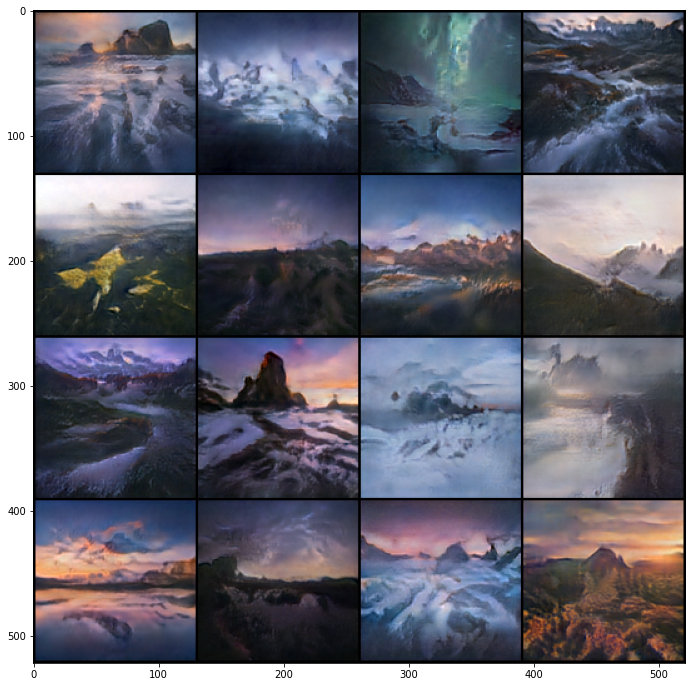

In [ ]:
seed = None
stage = 6
alpha = 1
np.random.seed(seed)
z = np.random.randn(16, z_dim)

np.random.seed(None)
z = torch.from_numpy(z).float().to(device)
gen.eval()
images = gen.forward(z, stage, alpha, truncation_psi=0.8, noise=1)
plt.rcParams['figure.figsize'] = (12, 12)
show_tensor_images(images, (3, images.shape[2], images.shape[2]), 16)
del images
del z